In [3]:
%matplotlib notebook

In [56]:
import random
import numpy as np
import graph_tool as gt
from graph_tool import Graph, GraphView
from graph_tool.topology import random_spanning_tree
from graph_tool.generation import complete_graph, lattice
from graph_tool.draw import planar_layout, graph_draw

from tqdm import tqdm

from cascade_generator import si, observe_cascade
from graph_helpers import extract_steiner_tree, filter_graph_by_edges, extract_edges, extract_nodes, gen_random_spanning_tree
from viz_helpers import lattice_node_pos

In [76]:
random.seed(1234)
np.random.seed(1234)
shape = (10, 10)
g = lattice(shape)


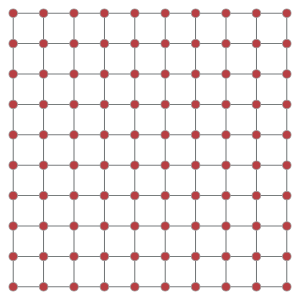

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fca758ddcf8, at 0x7fca758dd898>

In [39]:
pos = lattice_node_pos(g, shape)
graph_draw(g, pos=pos, output_size=(300, 300))    

In [7]:
s, c, t = si(g, 0.1)
o = observe_cascade(c, s, 0.2)
print(o)

[47 32 46 54  7 57 18 12 65 36  5]


In [300]:
sample_count = 500
steiner_trees_1 = []
for _ in tqdm(range(sample_count)):
    rand_t = gen_random_spanning_tree(g)
    st = extract_steiner_tree(rand_t, o)
    steiner_trees_1.append(st)

100%|██████████| 500/500 [00:44<00:00, 10.49it/s]


In [301]:
from core import det_score_of_steiner_tree
det_scores = [det_score_of_steiner_tree(st, g) for st in tqdm(steiner_trees_1)]

100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


In [302]:
real_scores = np.exp([-st.num_edges() for st in steiner_trees_1])

<IPython.core.display.Javascript object>


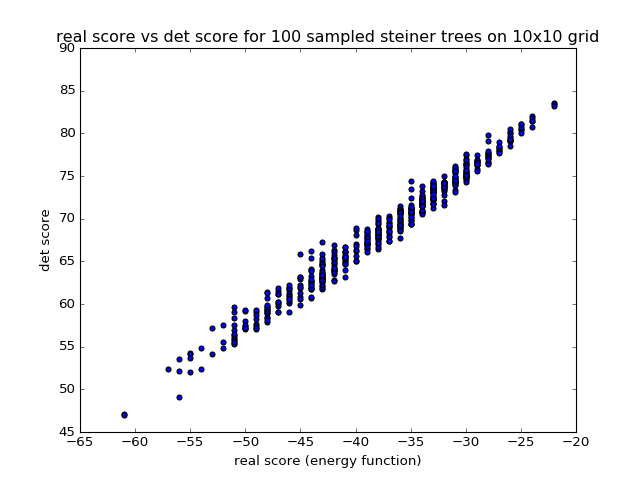

In [309]:
from matplotlib import pyplot as plt
plt.figure()
plt.scatter(np.log(real_scores), np.log(det_scores))
plt.xlabel('real score (energy function)')
plt.ylabel('det score')
plt.title('real score vs det score for 100 sampled steiner trees on 10x10 grid')

In [310]:
sampling_importance = real_scores / np.array(det_scores)
print(sampling_importance[:10])
sampling_importance /= sampling_importance.sum()
print(sampling_importance)

[  6.51807891e-47   4.95969636e-47   1.60110541e-46   9.87995411e-47
   4.27801061e-47   3.89985035e-47   2.88451120e-47   1.14968995e-46
   1.16510502e-46   5.30434081e-47]
[  1.12415316e-03   8.55383685e-04   2.76137761e-03   1.70396551e-03
   7.37815424e-04   6.72595279e-04   4.97482837e-04   1.98283514e-03
   2.00942105e-03   9.14823460e-04   1.90145908e-03   7.28460768e-04
   2.94315555e-04   2.32754676e-03   2.69646315e-04   8.29122715e-03
   6.99273463e-04   1.84894889e-04   5.01741049e-04   3.15604884e-03
   3.51333224e-03   3.10629061e-03   8.00486431e-04   2.77609250e-04
   3.63060552e-04   2.93069723e-03   1.43476762e-03   3.86087162e-03
   2.59929495e-03   3.92493817e-04   4.26536127e-03   4.31678638e-04
   3.94689248e-04   1.96463326e-03   1.32750300e-03   1.40711820e-03
   5.06105363e-03   3.84245269e-03   8.22129792e-04   1.98041328e-03
   3.46029999e-04   2.22922293e-04   9.40004096e-04   5.10887835e-04
   5.73686672e-03   3.83262308e-04   1.56458533e-03   1.19330306e-0

In [315]:
from numpy import random
m = 100
resampled_ids = random.choice(np.arange(len(steiner_trees_1)), m, replace=False, p=sampling_importance)

In [316]:
c = np.zeros(len(steiner_trees_1))
c[resampled_ids] = 1

<IPython.core.display.Javascript object>


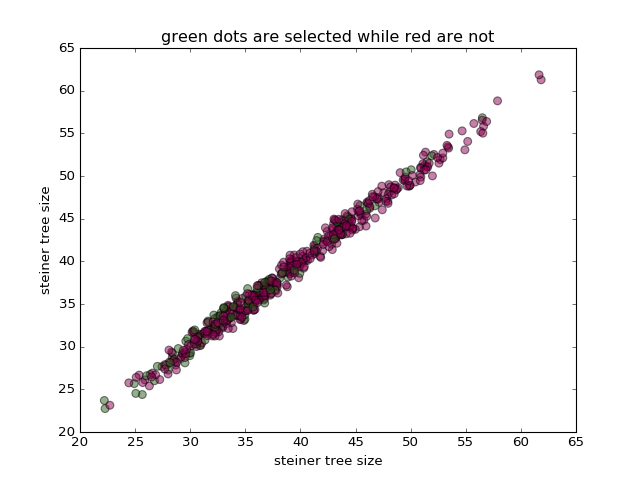

In [317]:
sizes = np.array([st.num_edges() for st in steiner_trees_1])
plt.figure()
plt.clf()
x = sizes + random.rand(len(steiner_trees_1)) * 2
y = sizes + random.rand(len(steiner_trees_1)) * 2
plt.scatter(x, y, c=c, s=50, cmap='PiYG', alpha=0.5)
plt.xlabel('steiner tree size')
plt.ylabel('steiner tree size')
plt.title('green dots are selected while red are not')

In [318]:
steiner_tree_samples = [steiner_trees_1[i] for i in resampled_ids]

In [281]:
def node_occurrence_freq(n, trees):
    yes = 1  # smoothing
    no = 1
    for t in trees:
        try:
            t.vertex(n)
            yes += 1
        except ValueError:
            no += 1
    return yes, no

In [283]:
def entropy_uncertainty(n, trees):
    yes, no = node_occurrence_freq(n, trees)
    p = np.array([yes, no], dtype=np.float32)
    p /= p.sum()
    return entropy(p)
    

In [284]:
def count_uncertainty(n, trees):
    yes, no = node_occurrence_freq(n, trees)
    return min(yes, no)

In [320]:
non_obs_nodes = set(extract_nodes(g)) - set(o)

entropy_uncertainties = {n: entropy_uncertainty(n, steiner_tree_samples)
                         for n in non_obs_nodes}
count_uncertainties = {n: count_uncertainty(n, steiner_tree_samples)
                         for n in non_obs_nodes}


In [321]:
vcolor = g.new_vertex_property('int')
vcolor.set_value(1)
for i in o:
    vcolor[i] = 2

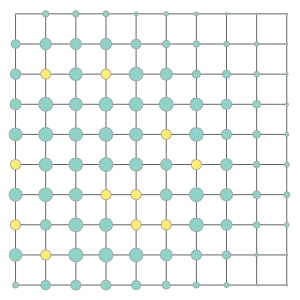

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fca758ddcf8, at 0x7fca758dd898>

In [327]:
vsize = g.new_vertex_property('float')
vsize.set_value(10)
for n, uncert in entropy_uncertainties.items():
    vsize[n] = uncert * 20
graph_draw(g, pos=pos, output_size=(300, 300), vertex_size=vsize, vertex_fill_color=vcolor,
           output='figs/concept-proof-entropy.pdf')

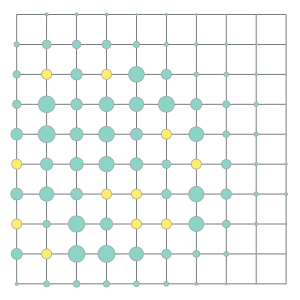

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fca758ddcf8, at 0x7fca758dd898>

In [328]:
vsize = g.new_vertex_property('float')
vsize.set_value(10)
for n, uncert in count_uncertainties.items():
    vsize[n] = uncert/3
graph_draw(g, pos=pos, output_size=(300, 300), vertex_size=vsize, vertex_fill_color=vcolor, 
           output='figs/concept-proof-count.pdf')